In [0]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from PIL import Image
from tqdm import tqdm
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
class BaseDataProvider(object):
    channels = 1
    n_class = 1

    def __init__(self, a_min=None, a_max=None):
        self.a_min = a_min if a_min is not None else -np.inf
        self.a_max = a_max if a_min is not None else np.inf

    def _load_data_and_label(self):
        data, label = self._next_data()

        train_data = self._process_data(data)
        labels = self._process_labels(label)

        train_data, labels = self._post_process(train_data, labels)

        nx = train_data.shape[1]
        ny = train_data.shape[0]

        return train_data.reshape(1, ny, nx, self.channels), labels.reshape(1, ny, nx, self.n_class),

    def _process_labels(self, label):
        if self.n_class == 2:
            nx = label.shape[1]
            ny = label.shape[0]
            labels = np.zeros((ny, nx, self.n_class), dtype=np.float32)

            # It is the responsibility of the child class to make sure that the label
            # is a boolean array, but we a chech here just in case.
            if label.dtype != 'bool':
                label = label.astype(np.bool)

            labels[..., 1] = label
            labels[..., 0] = ~label
            return labels

        return label

    def _process_data(self, data):
        # normalization
        data = np.clip(np.fabs(data), self.a_min, self.a_max)
        data -= np.amin(data)

        if np.amax(data) != 0:
            data /= np.amax(data)

        return data

    def _post_process(self, data, labels):
        """
        Post processing hook that can be used for data augmentation
        :param data: the data array
        :param labels: the label array
        """
        return data, labels

    def __call__(self, n):
        train_data, labels = self._load_data_and_label()
        nx = train_data.shape[1]
        ny = train_data.shape[2]

        X = np.zeros((n, nx, ny, self.channels))
        Y = np.zeros((n, nx, ny, self.n_class))

        X[0] = train_data
        Y[0] = labels
        for i in range(1, n):
            train_data, labels = self._load_data_and_label()
            X[i] = train_data
            Y[i] = labels

        return X, Y

class GrayScaleDataProvider(BaseDataProvider):
    channels = 1
    n_class = 2
    
    def __init__(self, nx, ny, **kwargs):
        super(GrayScaleDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3
        
    def _next_data(self):
        return create_image_and_label(self.nx, self.ny, **self.kwargs)

class RgbDataProvider(BaseDataProvider):
    channels = 3
    n_class = 2
    
    def __init__(self, nx, ny, **kwargs):
        super(RgbDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3

        
    def _next_data(self):
        data, label = create_image_and_label(self.nx, self.ny, **self.kwargs)
        return to_rgb(data), label

def create_image_and_label(nx,ny, cnt = 10, r_min = 5, r_max = 50, border = 92, sigma = 20, rectangles=False):
    
    
    image = np.ones((nx, ny, 1))
    label = np.zeros((nx, ny, 3), dtype=np.bool)
    mask = np.zeros((nx, ny), dtype=np.bool)
    for _ in range(cnt):
        a = np.random.randint(border, nx-border)
        b = np.random.randint(border, ny-border)
        r = np.random.randint(r_min, r_max)
        h = np.random.randint(1,255)

        y,x = np.ogrid[-a:nx-a, -b:ny-b]
        m = x*x + y*y <= r*r
        mask = np.logical_or(mask, m)

        image[m] = h

    label[mask, 1] = 1
    
    if rectangles:
        mask = np.zeros((nx, ny), dtype=np.bool)
        for _ in range(cnt//2):
            a = np.random.randint(nx)
            b = np.random.randint(ny)
            r =  np.random.randint(r_min, r_max)
            h = np.random.randint(1,255)
    
            m = np.zeros((nx, ny), dtype=np.bool)
            m[a:a+r, b:b+r] = True
            mask = np.logical_or(mask, m)
            image[m] = h
            
        label[mask, 2] = 1
        
        label[..., 0] = ~(np.logical_or(label[...,1], label[...,2]))
    
    image += np.random.normal(scale=sigma, size=image.shape)
    image -= np.amin(image)
    image /= np.amax(image)
    
    if rectangles:
        return image, label
    else:
        return image, label[..., 1]




def to_rgb(img):
    img = img.reshape(img.shape[0], img.shape[1])
    img[np.isnan(img)] = 0
    img -= np.amin(img)
    img /= np.amax(img)
    blue = np.clip(4*(0.75-img), 0, 1)
    red  = np.clip(4*(img-0.25), 0, 1)
    green= np.clip(44*np.fabs(img-0.5)-1., 0, 1)
    rgb = np.stack((red, green, blue), axis=2)
    return rgb


In [0]:
nx = 560
ny = 560

In [0]:
generator = RgbDataProvider(nx, ny, cnt=20)

In [0]:
x_test, y_test = generator(1)

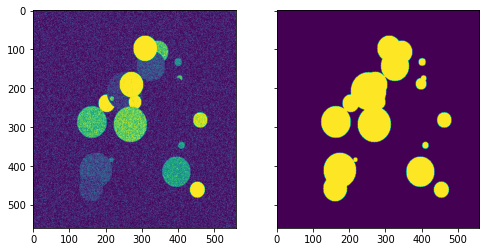

In [6]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
ax[0].imshow(x_test[0,...,0], aspect="auto")
ax[1].imshow(y_test[0,...,1], aspect="auto")

In [7]:
y_test[0,...,1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
x_train, y_train = generator(450)
x_val, y_val = generator(50)

In [9]:
x_train.shape, y_train.shape

((450, 560, 560, 3), (450, 560, 560, 2))

In [0]:
class param:
    bs = 8
    num_workers = 8
    lr = 0.001
    epochs = 3
    unet_depth = 5
    unet_start_filters = 8
    log_interval = 7

In [0]:
class ImgDataset(Dataset):
  def __init__(self, imgs, masks):
    self.imgs = imgs
    self.masks = masks

  def __getitem__(self, i):

    img = torch.Tensor(self.imgs[i])
    mask = torch.Tensor(self.masks[i])

    return img, mask
  
  def __len__(self):
    return len(self.imgs)

In [0]:
train_ds = ImgDataset(x_train, y_train)
val_ds = ImgDataset(x_val, y_val)

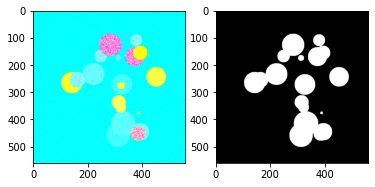

In [13]:
img, mask = train_ds[0]
plt.subplot(121)
plt.imshow(img.squeeze(2))
plt.subplot(122)
plt.imshow(mask[:,:,1], cmap='gray')
plt.show()

In [0]:
def conv1x1(in_channels, out_channels, groups=1):
  return nn.Conv2d(in_channels, out_channels, kernel_size=1, groups=groups, stride=1)

def conv3x3(in_channels, out_channels, stride=1, padding=1, bias=True, groups=1):
  return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=padding, bias=bias, groups=groups)

def upconv2x2(in_channels, out_channels, mode='transpose'):
  if mode == 'transpose':
    return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
  else:
    return nn.Sequential(nn.Upsample(mode='nearest', scale_factor=2), conv1x1(in_channels, out_channels))

In [0]:
class DownConv(nn.Module):
  
  def __init__(self, in_channels, out_channels, pooling=True):
    super(DownConv, self).__init__()

    self.in_channels = in_channels
    self.out_channels = out_channels
    self.pooling = pooling

    self.conv1 = conv3x3(self.in_channels, self.out_channels)
    self.conv2 = conv3x3(self.out_channels, self.out_channels)

    if self.pooling:
      self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, x):
    x = nn.functional.relu(self.conv1(x))
    x = nn.functional.relu(self.conv2(x))
    before_pool = x
    if self.pooling:
      x = self.pool(x)
    return x, before_pool

class UpConv(nn.Module):

  def __init__(self, in_channels, out_channels, merge_mode='concat', up_mode='transpose'): 
    super(UpConv, self).__init__()

    self.in_channels = in_channels
    self.out_channels = out_channels
    self.merge_mode = merge_mode
    self.up_mode = up_mode

    self.upconv = upconv2x2(self.in_channels, self.out_channels, mode=self.up_mode)

    if self.merge_mode == 'concat':
      self.conv1 = conv3x3(2 * self.out_channels, self.out_channels)
    else:
      self.conv1 = conv3x3(self.out_channels, self.out_channels)
      
    self.conv2 = conv3x3(self.out_channels, self.out_channels)

  def forward(self, from_down, from_up):
    from_up = self.upconv(from_up)
    if self.merge_mode == 'concat':
      x = torch.cat((from_up, from_down), 1)
    else:
      x = from_up + from_down
    x = nn.functional.relu(self.conv1(x))
    x = nn.functional.relu(self.conv2(x))
    return x

In [0]:
class UNet(nn.Module):

  def __init__(self, num_classes, in_channels=3, depth=5, start_filts=64, up_mode='transpose', merge_mode='concat'):

    super(UNet, self).__init__()

    if up_mode in ('transpose', 'upsample'):
        self.up_mode = up_mode
    else:
        raise ValueError("\"{}\" is not a valid mode for "
                          "upsampling. Only \"transpose\" and "
                          "\"upsample\" are allowed.".format(up_mode))

    if merge_mode in ('concat', 'add'):
        self.merge_mode = merge_mode
    else:
        raise ValueError("\"{}\" is not a valid mode for"
                          "merging up and down paths. "
                          "Only \"concat\" and "
                          "\"add\" are allowed.".format(up_mode))

    # NOTE: up_mode 'upsample' is incompatible with merge_mode 'add'
    if self.up_mode == 'upsample' and self.merge_mode == 'add':
        raise ValueError("up_mode \"upsample\" is incompatible "
                          "with merge_mode \"add\" at the moment "
                          "because it doesn't make sense to use "
                          "nearest neighbour to reduce "
                          "depth channels (by half).")

    self.num_classes = num_classes
    self.in_channels = in_channels
    self.start_filts = start_filts
    self.depth = depth

    self.down_convs = []
    self.up_convs = []

    for i in range(depth):
        ins = self.in_channels if i == 0 else outs
        outs = self.start_filts*(2**i)
        pooling = True if i < depth-1 else False
        down_conv = DownConv(ins, outs, pooling=pooling)
        self.down_convs.append(down_conv)

    for i in range(depth-1):
        ins = outs
        outs = ins // 2
        
        up_conv = UpConv(ins, outs, up_mode=up_mode,
            merge_mode=merge_mode)
        self.up_convs.append(up_conv)

    self.conv_final = conv1x1(outs, self.num_classes)

    self.down_convs = nn.ModuleList(self.down_convs)
    self.up_convs = nn.ModuleList(self.up_convs)

    self.reset_params()

  @staticmethod
  def weight_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0)


  def reset_params(self):
    for i, m in enumerate(self.modules()):
        self.weight_init(m)

  def forward(self, x):
    encoder_outs = []

    # encoder pathway, save outputs for merging
    for i, module in enumerate(self.down_convs):
        x, before_pool = module(x)
        encoder_outs.append(before_pool)

    for i, module in enumerate(self.up_convs):
        before_pool = encoder_outs[-(i+2)]
        x = module(before_pool, x)

    x = self.conv_final(x)
    return x

In [0]:
train_dl = DataLoader(train_ds, batch_size=param.bs, shuffle=True, pin_memory=torch.cuda.is_available(), num_workers=param.num_workers)
val_dl = DataLoader(val_ds, batch_size=param.bs, shuffle=False, pin_memory=torch.cuda.is_available(), num_workers=param.num_workers)

model = UNet(2, depth=param.unet_depth, start_filts=param.unet_start_filters, up_mode='upsample', merge_mode='concat').cuda()
optim = torch.optim.Adam(model.parameters(), lr=param.lr)
criterion = nn.CrossEntropyLoss()

In [0]:
def get_loss(dl, model):
  loss = 0
  for X, y in dl:
    X = X.permute(0, 3, 1, 2)
    y = y.permute(0, 3, 1, 2)
    X, y = Variable(X).cuda(), Variable(y).cuda()
    y = y.long()[:,1,:,:]
    output = model(X)
    loss += nn.functional.cross_entropy(output, y).item()
  loss = loss / len(dl)
  
  return loss

In [19]:
iters = []
train_losses = []
val_losses = []

it = 0
min_loss = np.inf
n_train = len(train_ds)

model.train()
for epoch in range(param.epochs):
  with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{param.epochs}', unit='img') as pbar:
    i = 1
    for batch in train_dl:
      imgs = batch[0]
      masks = batch[1]
      imgs = imgs.permute(0, 3, 1, 2)
      masks = masks.permute(0, 3, 1, 2)
      
      X = Variable(imgs).cuda() 
      y = Variable(masks).cuda()
      y = y.long()[:,1,:,:]
      output = model(X)
      loss = criterion(output, y)

      pbar.set_postfix(**{'loss (batch)': loss.item()})

      optim.zero_grad()
      loss.backward()
      optim.step()

      pbar.update(imgs.shape[0])

      if (i + 1) % param.log_interval == 0:
        it += param.log_interval * param.bs
        iters.append(it)
        train_losses.append(loss.item())

        model.eval()
        val_loss = get_loss(val_dl, model)
        model.train()
        val_losses.append(val_loss)
      i += 1

model.eval()
val_loss = get_loss(val_dl, model)

Epoch 3/3: 100%|██████████| 450/450 [00:51<00:00,  8.81img/s, loss (batch)=0.0749]


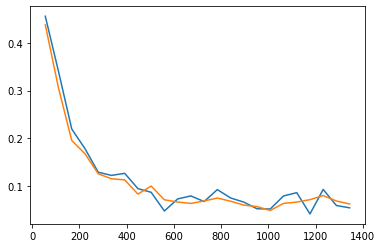

In [20]:
plt.plot(iters, train_losses)
plt.plot(iters, val_losses)
plt.show()

In [0]:
model.eval()
for X, masks in val_dl:
  X = X.permute(0, 3, 1, 2)
  X = X.cuda()
  output = model(X)
  break

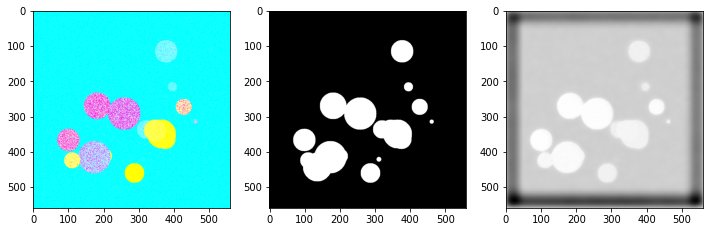

In [26]:
num_item = 5
image, mask, predicted = X[num_item],  masks[num_item], output[num_item, 1]
plt.figure(figsize=(12,4))
plt.subplot(131) 
plt.imshow(image.permute(1,2,0).cpu())
plt.subplot(132)
plt.imshow(mask[:,:,1].cpu(), cmap='gray')
plt.subplot(133)
plt.imshow(predicted.detach().cpu(), cmap='gray')
plt.show()